# Analysis on Average Sales Price (ASP)


ASP figures get thrown around a lot. It's easy to throw around numbers but if you want something meaningful you need to define what you mean by ASP.  The typical goal of this metric is to give you an estimate for the per/seat price of software. This analysis looks at different definitions of ASP for AWR products.

Some Notes:
  * ASP is sometimes used to mean Average Order Value. This is not covered in this document.  Here we only look at price per seat/price per product.
  * We only have product data since 1/1/2015 so that is all that is included in this document

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import math
import pylab
pylab.rcParams['figure.figsize'] = (12,8)
def fd(x):
    return "{:,}".format(int(x))

In [24]:
import os
os.chdir('/Users/dane/src/datatools/ipy/notebooks/products/dev') # this output cleaner than using %cd

In [25]:
opps = pd.read_csv('../data/exported_products.csv')

# required cleaning

# 1 - some test orders have close dates > today
mask1 = opps.close_year < 2018

# 2 - remove hardware keys
mask2 = opps.base_pn != 'HWK_200'

# 3 - training and university products don't matter
mask3 = ~opps.base_pn.isin(['UNV_999', 'TRN_100', 'TRN_200', 'LHC_100'])

# 4 - eliminate things put in at $0
mask4 = opps.amt_usd > 0

opps = opps[mask1 & mask2 & mask3 & mask4]

print('This analysis covers {} opportunities '.format(len(opps)), end='')
print('from {} to {}'.format(opps.close_year.min(), opps.close_year.max()))

This analysis covers 3683 opportunities from 2015 to 2017


In [26]:
# check which products have bad part numbers
import re
pat = re.compile('[A-Z][A-Z][A-Z]_[0-9][0-9][0-9]_[A-Z][A-Z0-9][A-Z]')
bad_pn = opps[opps.full_pn.apply(lambda x: True if pat.match(x)==None else False)]
good_pn = opps[~opps.full_pn.apply(lambda x: True if pat.match(x)==None else False)].copy()


## Product ASP

ASP is usually determined at the product level.  When determining ASP we have to remember that:

  * It does not make sense to combine term, perpetual and maintenance products together
  * Maintenance and Term products are for various terms and need to be normalized to a /year ASP
  
We have a lot of different part numbers.  Looking at the ASP of all part numbers will just get us a sea of data which will be hard to absorb so we'll focus on just some representative products.

36% of our term/perpetual licenses sold in 2015-2016 were of MWO-226, MWO-246, MWO-106 or VSS-250 so we will look at those.


In [27]:
keep = ['MWO_246', 'MWO_226', 'MWO_106', 'VSS_250']
pmt = good_pn[good_pn.base_pn.isin(keep)].copy()

# make sure all purchase orders have years set to 1 so per_year computes correctly
pmt.loc[pmt.order_type=='Purchase','years'] = 1

Perpetual licenses are the simplest since we can just compute the ASP directly by taking the total sales and dividing by the total quantity.

In [28]:
print('For Perpetual')
for pn in keep:
    perp = pmt[(pmt.order_code=='P') & (pmt.base_pn == pn)]
    print('    {} ASP = ${}'.format(pn, fd(perp.amt_usd.sum() / perp.quantity.sum())))

For Perpetual
    MWO_246 ASP = $33,845
    MWO_226 ASP = $18,300
    MWO_106 ASP = $14,625
    VSS_250 ASP = $14,449


For term and maintenance products we will look at the per-year value.

In [29]:
# add the per_year column
pmt['per_year'] = pmt.amt_usd / pmt.years

for code, typ in [('T', 'Term'), ('M', 'Maintenance')]:
    print('For {}'.format(typ))
    for pn in keep:
        df = pmt[(pmt.order_code==code) & (pmt.base_pn == pn)]
        print('    {} ASP = ${}'.format(pn, fd(df.per_year.sum() / df.quantity.sum())))

For Term
    MWO_246 ASP = $13,059
    MWO_226 ASP = $10,838
    MWO_106 ASP = $6,210
    VSS_250 ASP = $7,462
For Maintenance
    MWO_246 ASP = $9,494
    MWO_226 ASP = $6,427
    MWO_106 ASP = $3,452
    VSS_250 ASP = $4,086


## Overall ASP

We can apply the same methodology to the overall product line by combining all products.


In [30]:
good_pn['per_year'] = good_pn.amt_usd / good_pn.years
for code, typ in [('P', 'Perpetual'), ('M', 'Maintenance'), ('T', 'Term')]:
    print('For {}'.format(typ))
    df = pmt[(pmt.order_code==code)]
    print('    ASP = ${}'.format(fd(df.per_year.sum() / df.quantity.sum())))

For Perpetual
    ASP = $19,470
For Maintenance
    ASP = $5,956
For Term
    ASP = $9,221


So this figure gives us the overall ASP but is that useful?  How many FIL-300's are in that ASP, or IGS-002's.  When people think of ASP it tends to represent the average price of a seat and we have many add-on products that are being counted here but don't actually create new seats.

And this is where things get somewhat ambiguous.  What is a "seat" of our software.  It's easy to say that MWO-226 is a seat but is XEM-100?  Is VSS-250?  This gets tricker.  You can't run XEM-100 without a MWO-226 license (or equivalent) but you can run VSS-250, but very few people do (for 2017 0.2%).  For most of our customers, vss is an add-on to MWO.

In addition, sometimes we combine EM simulators into kits so they are not counted in the kit version but they are counted in the stand-alone version in the computations above.

The most reasonable thing to do, is to treat the number of front-end MWO seats as the number of seats rather than counting all of the part numbers.

First, let's just compute the ASP of just the MWO-XXX products.

In [31]:
gains = pd.DataFrame(columns = ['base_mwo', 'with_options'], index=['Perpetual', 'Maintenance', 'Term'])
mwo = good_pn[good_pn.base_pn.apply(lambda x: x[:3] == 'MWO')]
for code, typ in [('P', 'Perpetual'), ('M', 'Maintenance'), ('T', 'Term')]:
    print('For {}'.format(typ))
    df = mwo[(mwo.order_code==code)]
    asp = df.per_year.sum() / df.quantity.sum()
    gains.loc[typ, 'base_mwo'] = asp
    print('   ASP = $', fd(asp))


For Perpetual
   ASP = $ 20,884
For Maintenance
   ASP = $ 6,016
For Term
   ASP = $ 10,582


Next we want to see how the add-on products add to this ASP.  We will do this by including the revenue for products such as VSS, Axiem and Analyst but not increasing the seat count.

In [32]:
mwo = good_pn[good_pn.base_pn.apply(lambda x: x[:3] == 'MWO')]
for code, typ in [('P', 'Perpetual'), ('M', 'Maintenance'), ('T', 'Term')]:
    print('For {}'.format(typ))
    df = good_pn[(good_pn.order_code==code)]
    asp = df.per_year.sum() / mwo[mwo.order_code==code].quantity.sum()
    print('   ASP = $', fd(asp))
    gains.loc[typ, 'with_options'] = asp

For Perpetual
   ASP = $ 27,424
For Maintenance
   ASP = $ 8,224
For Term
   ASP = $ 17,221


From this we can see that add-on products (VSS+EM mostly) add a significant amount to the overall ASP, especially in the case of the term products.

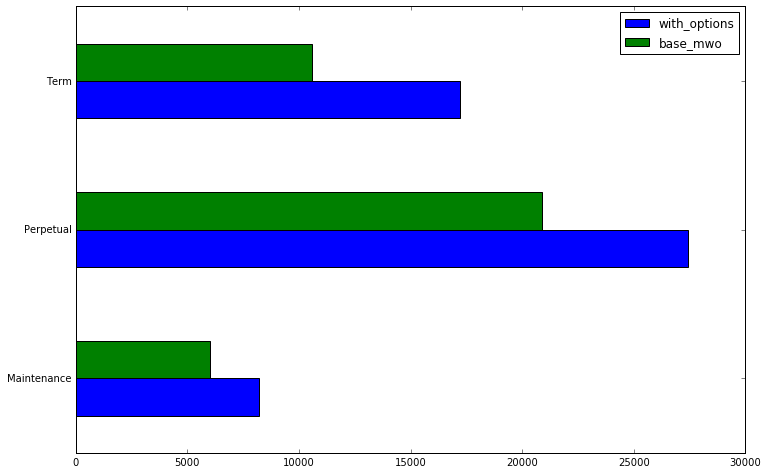

In [33]:
gains.iloc[[1,0,2],[1,0]].plot(kind='barh', stacked=False)
plt.show()

## ASP increases in bundles

When we create bundles we determine the markup for the products we're including but how does that translate to what happens in the field once we've applied discounts?

For example, the markup for going from MWO-226 to MWO-246 (which adds Axiem) is 19,400 (floating). 
As we saw above, this translates to an increased ASP of 15,901 which is substantial.  Let's see if that applies to other bundles as well.

In [34]:
keep = ['MWO_226', 'MWO_246', 'MWO_286', 'MWO_106', 'MWO_146', 'MWO_186']
compare = pd.DataFrame(index=keep, columns=['Perp_List', 'ASP'])
compare.loc[:, 'Perp_List'] = [41200, 60600, 91000, 21700, 47700, 73700]

pmt = good_pn[good_pn.base_pn.isin(keep)].copy()
for pn in keep:
    perp = pmt[(pmt.order_code=='P') & (pmt.base_pn == pn)]
    asp = perp.amt_usd.sum() / perp.quantity.sum()
    print('    {} ASP = ${}'.format(pn, fd(asp)))
    compare.loc[pn, 'ASP'] = asp

    MWO_226 ASP = $18,300
    MWO_246 ASP = $33,845
    MWO_286 ASP = $48,543
    MWO_106 ASP = $14,625
    MWO_146 ASP = $29,937
    MWO_186 ASP = $34,497


In [35]:
pairs = [('MWO_246', 'MWO_226'), ('MWO_286', 'MWO_226'), ('MWO_146', 'MWO_106'),('MWO_186', 'MWO_106')]
compare['ASP_PCT'] = 100 * compare.ASP / compare.Perp_List
compare['ASP_PCT'] = compare.ASP_PCT.apply(lambda x: round(x, 1))
for addon, base in pairs:
    compare.loc[addon, 'List_delta'] = int(compare.loc[addon, 'Perp_List'] - compare.loc[base, 'Perp_List'])
    compare.loc[addon, 'ASP_delta'] = int(compare.loc[addon, 'ASP'] - compare.loc[base, 'ASP'])

compare

,Perp_List,ASP,ASP_PCT,List_delta,ASP_delta
MWO_226,41200,18300.77,44.4,NaN,NaN
MWO_246,60600,33845.21,55.9,19400,15544
MWO_286,91000,48543.4,53.3,49800,30242
MWO_106,21700,14625.46,67.4,NaN,NaN
MWO_146,47700,29937.63,62.8,26000,15312
MWO_186,73700,34497.96,46.8,52000,19872


This table is quite interesting.  We see that even though the list price deltas for adding Axiem and Axiem+Analyst are higher for MWO_1xx the average selling price is lower (significantly lower in the case of Analyst).